# Topas Work - Team protons and heavy ions
### PHY-7051 Physique des radiations en radiothérapie et en radiologie
Gabrielle Germain (111 266 117), Hanieh Sadat Jozi (111 XXX XXX), Philippe Dionne (111 265 307)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Useful functions

In [12]:
def csv_to_data(path:str, skiprows:int=9, delimiter:str=',') -> tuple:
    """ Reads the csv file and converts it to a tuple containing 3 columns matrices

    Args:
        path (str): absolute path on the computer. Must have the format r"C:\path.csv"
        skiprows (int, optional): Rows to skip the header. Defaults to 9.
        delimiter (str, optional): Defaults to ', '.

    Returns:
        tuple: (bin, dose, standard-deviation)
    """

    data = np.loadtxt(path, skiprows=skiprows, delimiter=delimiter, usecols=(2, 3, 4))
    bin = data[:, 0]
    dose = data[:, 1]
    std = data[:, 2]
    return (bin, dose, std)

def droite(x, a, b):
    return a*x + b

Constants

In [13]:
MeV_to_joule = 1.602176565e-13 # J/MeV

## Central-axis depth-dose distribution in water of a monoenergetic beam of protons or carbon ions

### Reproduction de la figure 6.12 du manuel [1]

__Attention__: La mise en forme du code est grandement inspirée du notebook jupyter de l'équipe électrons de l'automne 2022. Le code est toutefois original, même s'il est similaire à certains endroits.

Aussi, les _path_ sont absolus, les paths relatifs ne fonctionnaient pas...

### Mise en contexte

Lors de son interaction avec la matière, les faisceaux de protons ou d'ions lourds déposent leur dose de manière assez différente des faisceaux de photons ou d'électrons. Comme ces particules sont plus lourdes, leur pouvoir d'arrêt à haute vitesse est plus bas qu'à basse vitesse, ce qui veut dire qu'à haute vitesse, ces particules déposent peu d'énergie. Toutefois, dès qu'elles commencent à ralentir et à déposer de l'énergie, elles déposent cette énergie rapidement et sur une courte distance. Ce phénomène crée un pic de Bragg à une distance spécifique. Pour cette raison, la radiothérapie par faisceaux de protons ou d'ions lourds peut être avantageuse chez des enfants, une clientèle chez qui on cherche à réduire la dose (encore plus que les adultes ou les aînés, puisqu'ils ont plus de temps pour développer un cancer). En effet, il est possible d'aller porter un maximum d'énergie dans une zone de traitement se situant à plusieurs centimètres de profondeur, en déposant un minimum d'énergie au passage, contrairement aux faisceaux de photons qui déposent un maximum d'énergie quelques millimètres seulement après avoir pénétré le corps.

La section suivante explore les différents effets de l'énergie du faisceau et du type de faisceau sur l'aspect et la profondeur du pic de Bragg. La figure 6.12 du livre _Fundamentals of ionizing radiation dosimetry_ par P. Andreo n'a pas pu être reproduite exactement. Des hypothèses sur ces différences seront explorées dans un paragraphe qui suivra le code d'analyse et les figures. L'hypothèse principale est que la combinaison de _physics list_ utilisée lors de la simulation n'est pas la même.

Au total, quatre combinaisons de _physics list_ ont été testées afin de reproduire la figure 6.12 du manuel. Ces combinaisons sont les suivantes:
* "g4em-standard_opt4" 
* "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"
* "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" 
* "g4em-standard_opt4" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"

In [14]:
# ------------------------------- Paramètres  identiques pour tous les essais------------------------------------------- #

field_size = 100 # cm2
energies_p = np.array([122, 183, 230])      # MeV
energies_c = np.array([220, 350, 430])      # MeV/u, u = 12
nbr_p = 100000 # nbr de protons simulés pour chaque énergie
nbr_c = 10000 # nbr d'ions de carbone simulés pour chaque énergie
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
np.seterr(divide='ignore', invalid='ignore')
marker = ['-','--','-.',':','k-','k--','k-.','k:']


Protons de  122 MeV - Erreur relative suffisante atteinte!
0.0237 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0165 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00408 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.241 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.147 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0738 % < 3 %


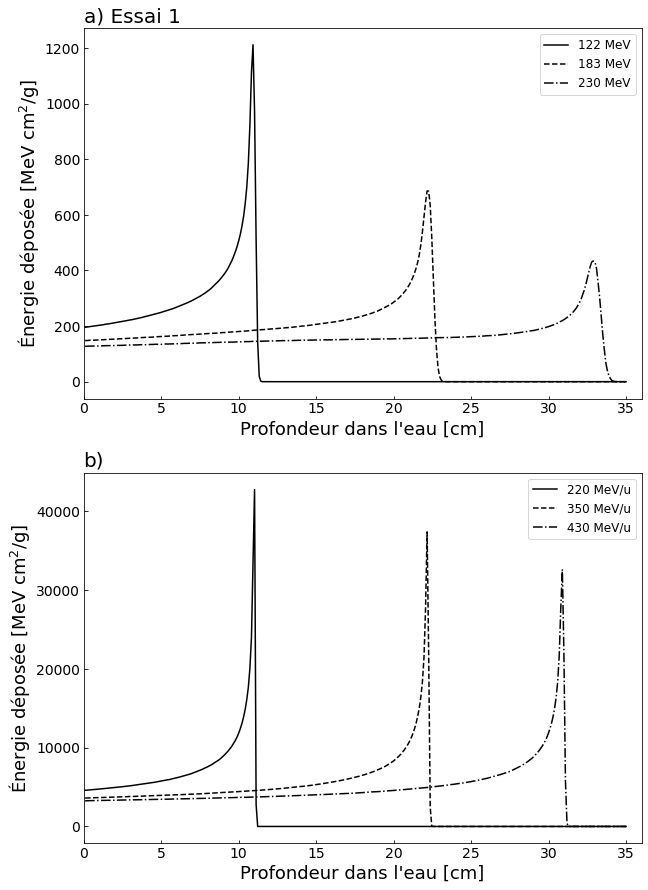

In [15]:
""" 
Essai 1 avec 1 module: "g4em-standard_opt4"
L'aspect général semble similaire, mais les hauteurs relatives des pics semblent un peu différentes. 
De plus, l'ordre de grandeur de la dose déposée est loin de celle présentée dans le manuel (pic à presque 1200 MeV/g, 
alors que dans le manuel ce pic est à environ 3.6 MeV/g)
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a) Essai 1",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v1.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v1.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')
fig1.savefig("v1.png", dpi=600)



Protons de  122 MeV - Erreur relative suffisante atteinte!
0.157 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0924 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00884 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.143 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.0452 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0263 % < 3 %


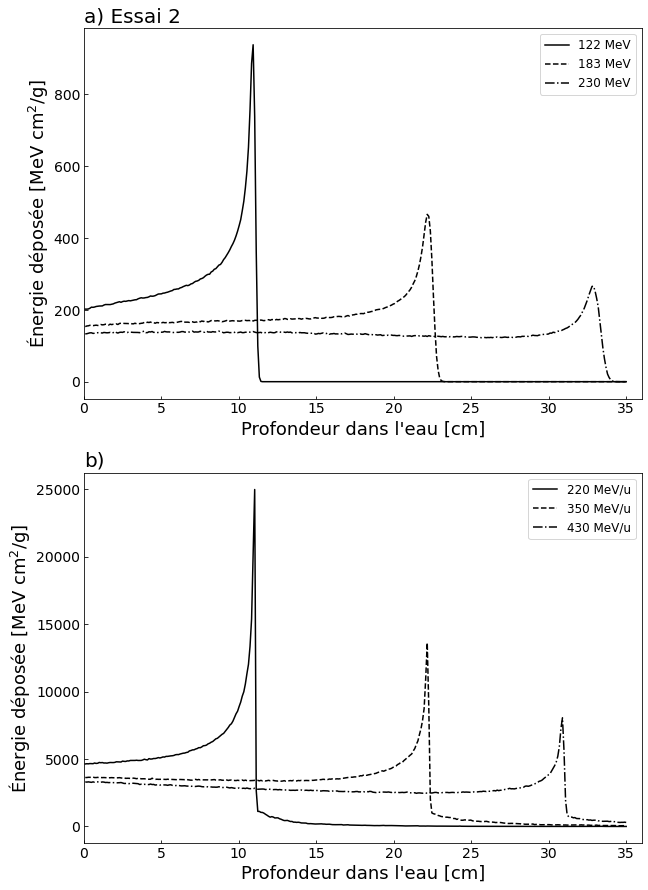

In [16]:
"""
Essai 2 avec 6 modules: "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"
On peut maintenant voir les effets des interactions nucléaires, toutefois, l'échelle de la dose n'est toujours pas la bonne
Cet essai a été utilisé pour évaluer les relations entre l'énergie, la position des pics de Bragg et Rp (régressions linéaires)
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
braggpeak_p = np.empty(np.size(energies_p))
Rp_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
braggpeak_c = np.empty(np.size(energies_c))
Rp_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a) Essai 2",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v2.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Pic de Bragg et Rp
    braggpeak_p[i] = depth[np.argmax(dose)]
    norm_dose = dose/np.max(dose)
    j = 0
    while norm_dose[j] > 0.1:
        j+=1
    Rp_p[i] = depth[j]

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v2.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Pic de Bragg et Rp
    braggpeak_c[i] = depth[np.argmax(dose)]
    norm_dose = dose/np.max(dose)
    j = 0
    while norm_dose[j] > 0.1:
        j+=1
    Rp_c[i] = depth[j]

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')
fig1.savefig("v2.png", dpi=600)



Protons de  122 MeV - Erreur relative suffisante atteinte!
0.103 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0669 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00791 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.241 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.147 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0738 % < 3 %


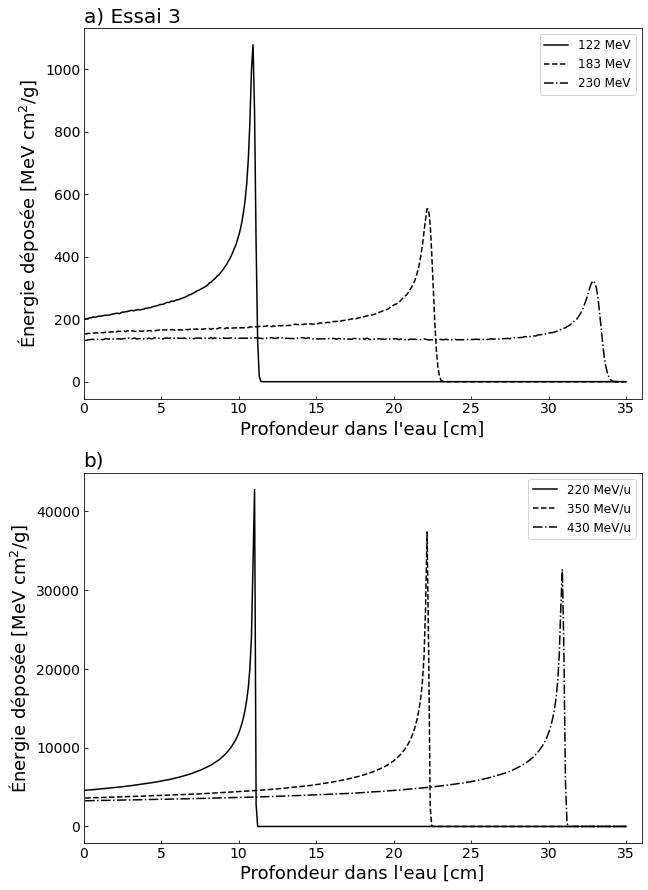

In [17]:
"""
Essai 3 avec modules: "g4em-standard_opt4" "g4h-phy_QGSP_BIC_HP"
On perd la queue après le pic dans la figure du carbone.
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

nbr_p = np.array([100000, 100000, 100000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 10000]) # nbr d'ions de carbone simulés pour chaque énergie
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a) Essai 3",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v3.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v3.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')
fig1.savefig("v3.png", dpi=600)


Protons de  122 MeV - Erreur relative suffisante atteinte!
0.0367 % < 3 %
Protons de  183 MeV - Erreur relative suffisante atteinte!
0.0192 % < 3 %
Protons de  230 MeV - Erreur relative suffisante atteinte!
0.00491 % < 3 %
Ion de carbone de  220 MeV/u - Erreur relative suffisante atteinte!
0.151 % < 3 %
Ion de carbone de  350 MeV/u - Erreur relative suffisante atteinte!
0.0448 % < 3 %
Ion de carbone de  430 MeV/u - Erreur relative suffisante atteinte!
0.0263 % < 3 %


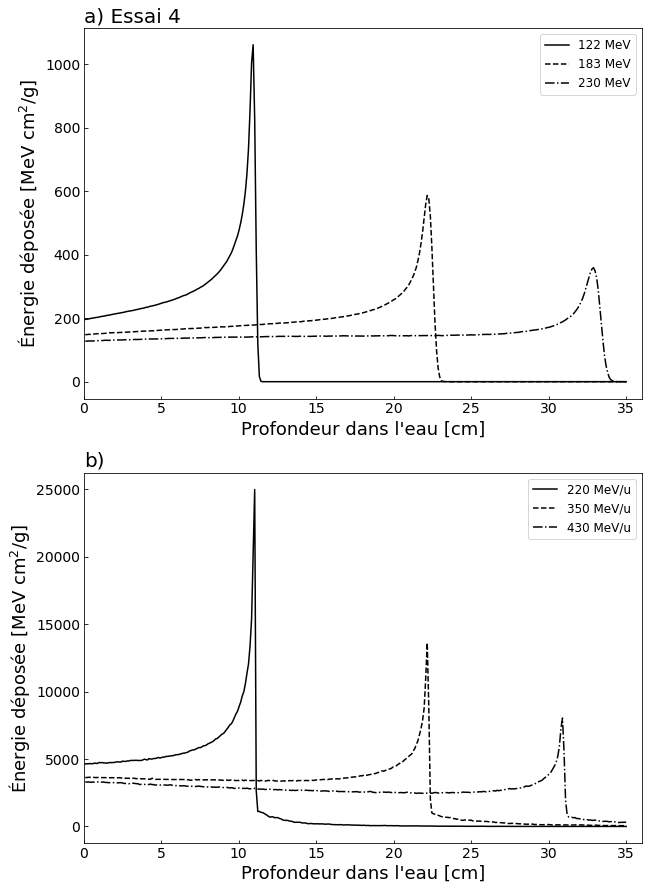

In [18]:
"""
Essai 4 avec modules: "g4em-standard_opt4" "g4decay" "g4ion-binarycascade" "g4h-elastic_HP" "g4stopping"
"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

nbr_p = np.array([100000, 100000, 100000]) # nbr de protons simulés pour chaque énergie
nbr_c = np.array([10000, 10000, 10000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([35, 35]) # profondeur des scorers pour chaque particule, en cm
in_fluence_p = nbr_p/field_size # cm-2
in_fluence_c = nbr_c/field_size # cm-2

# initialisation des données
std_rel_p = np.empty(np.size(energies_p))
Dmax_p = np.empty(np.size(energies_p))

std_rel_c = np.empty(np.size(energies_c))
Dmax_c = np.empty(np.size(energies_c))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 1)      # protons
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("a) Essai 4",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')
ax2 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.title("b)",  fontsize='20', loc="left")
plt.tick_params(direction='in',labelsize='14')

# ------------------------------- Fonctions de calcul ------------------------------------------- #
## Protons en premier
for i in range(len(energies_p)):
    energy = energies_p[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_protons_{}MeV_v4.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_p[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_p[i] < 3: # erreur maximale est choisie à 3%
        print("Protons de ", energy, "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel_p[i], '.3g'), "% <", "3 %")
    else:
        print("Protons de ", energy, "MeV - Erreur relative trop élevée")
        print(format(std_rel_p[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[0]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_p[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax1.plot(depth, dose, marker[i], label="{} MeV".format(energy), color="k")

ax1.set_xlim([0, 36])
# ax1.set_ylim([0, 1250])
ax1.legend(loc=0, frameon=True, fontsize='12')

## Carbone en second
for i in range(len(energies_c)):
    energy = energies_c[i]
    path = r"C:\Users\gabri\Documents\Université\Maitrise\Session 1\physique_radiations\Devoir\Topas_project\results\6_12_carbon_{}MeV_v4.csv".format(energy)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", energy, "MeV/u - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", energy, "MeV/u - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(1000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Figure
    ax2.plot(depth, dose, marker[i], label="{} MeV/u".format(energy), color="k")

ax2.set_xlim([0, 36])
# ax2.set_ylim([0, 45000])
ax2.legend(loc=0, frameon=True, fontsize='12')
fig1.savefig("v4.png", dpi=600)

### Extraction de la position des pics de Bragg et des Rp

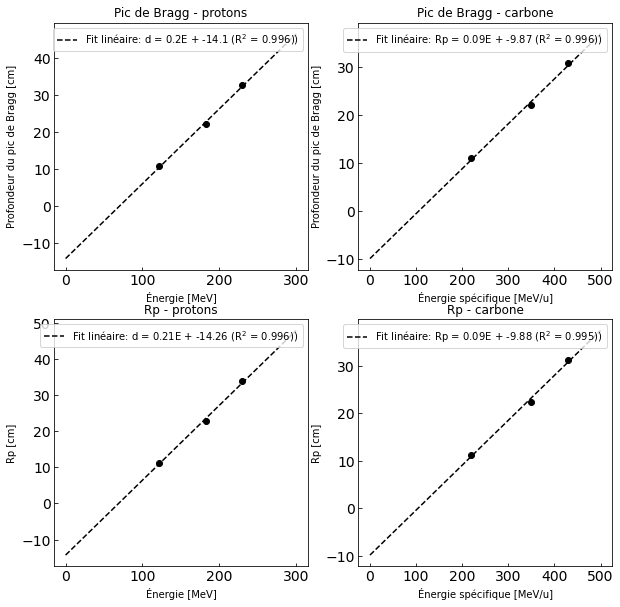

In [9]:
# Régressions linéaires
lin_energy_p = np.linspace(0, 300, 300)
lin_energy_c = np.linspace(0, 500, 500)

popt00, pcov00 = curve_fit(droite, energies_p, braggpeak_p)
popt10, pcov10 = curve_fit(droite, energies_p, Rp_p)
popt01, pcov01 = curve_fit(droite, energies_c, braggpeak_c)
popt11, pcov11 = curve_fit(droite, energies_c, Rp_c)

# R^2
residuals00 = braggpeak_p- droite(energies_p, *popt00)
ss_res00 = np.sum(residuals00**2)
ss_tot00 = np.sum((braggpeak_p-np.mean(braggpeak_p))**2)
r_squared00 = 1 - (ss_res00 / ss_tot00)

residuals10 = Rp_p- droite(energies_p, *popt10)
ss_res10 = np.sum(residuals10**2)
ss_tot10 = np.sum((Rp_p-np.mean(Rp_p))**2)
r_squared10 = 1 - (ss_res10 / ss_tot10)

residuals01 = braggpeak_c- droite(energies_c, *popt01)
ss_res01 = np.sum(residuals01**2)
ss_tot01 = np.sum((braggpeak_c-np.mean(braggpeak_c))**2)
r_squared01 = 1 - (ss_res01 / ss_tot01)

residuals11 = Rp_c- droite(energies_c, *popt11)
ss_res11 = np.sum(residuals11**2)
ss_tot11 = np.sum((Rp_c-np.mean(Rp_c))**2)
r_squared11 = 1 - (ss_res11 / ss_tot11)


### Figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# pic bragg proton
axs[0,0].plot(energies_p, braggpeak_p, 'ko')
axs[0,0].plot(lin_energy_p, droite(lin_energy_p, *popt00), 'k--', label="Fit linéaire: d = {}E + {} (R$^2$ = {}))".format(round(popt00[0],2),round(popt00[1],2), round(r_squared00, 3)))
axs[0,0].set(xlabel="Énergie [MeV]", ylabel="Profondeur du pic de Bragg [cm]")
axs[0,0].set_title("Pic de Bragg - protons")
axs[0,0].tick_params(direction='in',labelsize='14')
axs[0,0].legend()
# Rp proton
axs[1,0].plot(energies_p, Rp_p, 'ko')
axs[1,0].plot(lin_energy_p, droite(lin_energy_p, *popt10), 'k--', label="Fit linéaire: d = {}E + {} (R$^2$ = {}))".format(round(popt10[0],2),round(popt10[1],2), round(r_squared10, 3)))
axs[1,0].set(xlabel="Énergie [MeV]", ylabel="Rp [cm]")
axs[1,0].set_title("Rp - protons")
axs[1,0].tick_params(direction='in',labelsize='14')
axs[1,0].legend()
# pic bragg carbone
axs[0,1].plot(energies_c, braggpeak_c, 'ko')
axs[0,1].set(xlabel="Énergie spécifique [MeV/u]", ylabel="Profondeur du pic de Bragg [cm]")
axs[0,1].plot(lin_energy_c, droite(lin_energy_c, *popt01), 'k--', label="Fit linéaire: Rp = {}E + {} (R$^2$ = {}))".format(round(popt01[0],2),round(popt01[1],2), round(r_squared01, 3)))
axs[0,1].set_title("Pic de Bragg - carbone")
axs[0,1].tick_params(direction='in',labelsize='14')
axs[0,1].legend()
# Rp carbone
axs[1,1].plot(energies_c, Rp_c, 'ko')
axs[1,1].set(xlabel="Énergie spécifique [MeV/u]", ylabel="Rp [cm]")
axs[1,1].plot(lin_energy_c, droite(lin_energy_c, *popt11), 'k--', label="Fit linéaire: Rp = {}E + {} (R$^2$ = {}))".format(round(popt11[0],2),round(popt11[1],2), round(r_squared11, 3)))
axs[1,1].set_title("Rp - carbone")
axs[1,1].tick_params(direction='in',labelsize='14')
axs[1,1].legend()

fig.savefig("regressions.png", dpi=600)

### Discussion sur les différentes figures générées

La première chose à noter après cette analyse est que peu importe les modules de physique utilisés, les doses déposées étaient beaucoup plus grandes que ce qui était présenté dans le manuel (~1000 MeV/g vs ~3.6 MeV/g). Pourtant, la dose a été convertie de Gy à MeV/g et la fluence du faisceau a été prise en compte. Cette différence semble trop importante pour être causée seulement par une mauvaise combinaison de modules de physique. Malheureusement, la cause de cette différence n'a pas été identifiée (de toute évidence). Pour cette raison, la discussion portera sur l'allure général des courbes et la position des pics, plutôt que sur l'énergie déposée.

L'essai 1 présente des courbes avec des pics de Bragg à la bonne profondeur. Toutefois, pour le faisceau de carbone, la "queue" générée par la contribution de multiples ions n'est pas apparente. De plus, pour le faisceau de protons, la région du plateau avant le pic n'a pas exactement le bon aspect. En effet, un certaine renflement devrait être présent, mais celui-ci est absent de la figure de l'essai 1. Le renflement du plateau apparait toutefois lors des essais 2 3. Le module commun à ces deux essais est le "g4h-phy_QGSP_BIC_HP". La queue après le pic quant à elle est présente lors des essais 2 et 4. L'essai 2 semble donc être celui qui reproduit le mieux des différentes caractéristiques de la figure 6.12. C'est pour cette raison que les résultats obtenus avec cet essai ont été choisis pour effectuer l'analyse de la relation entre l'énergie du faisceau, la position du pic de Bragg et la valeur $R_p$ (diminution de la dose à 10% de la valeur maximale). 

Les équations des différentes régressions ont été données, même si les valeurs de dose calculées ne sont pas les mêmes que dans la figure de référence. En effet, la position des pics est la similaire (pour ne pas dire la même) dans le manuel et dans l'analyse précédente. La dose n'est même pas une variable considérée dans le calcul. Même si les régressions ont été réalisées avec seulement 3 points, on remarque un coefficient $R^2$ très élevé (>0.99) pour les 4 régressions. Cela laisse croire que le relation est bel et bien linéaire entre l'énergie du faisceau, la position du pic de Bragg et $R_p$, à tout le moins pour cette plage d'énergie.



## Depth of the Bragg Peak for a carbon ions beam

Un des arguments en faveur de l'utilisation de faisceau de proton ou d'ions lourds comme le carbone est que la majorité de la dose du faisceau peut être déposé de manière précise (précision sub-millimétrique) à l'endroit de son pic de Bragg. Cependant, comme il sera démontré ci-dessous, l'endroit où le pic de Bragg se trouve dépend de la _mean excitation energy_ du milieu qu'il traverse.

Tout d'abord, des simulations pour un faisceau d'ions de carbone à une énergie de 430 MeV/u ont été réalisé en définissant trois milieux d'eau avec des _mean excitation energy_ différents; soit de 67, 75 et 80 eV.

Ion de carbone de  67 eV - Erreur relative suffisante atteinte!
0.0517 % < 3 %
Ion de carbone de  75 eV - Erreur relative suffisante atteinte!
0.0511 % < 3 %
Ion de carbone de  80 eV - Erreur relative suffisante atteinte!
0.0523 % < 3 %


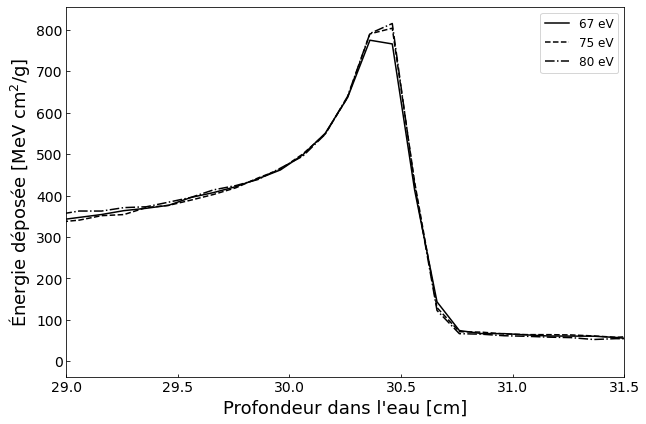

In [23]:
""" Le code ci-bas génère la figure 6.13 du manuel de référence, soit le dépôt de la dose à différentes profondeurs dans un fantôme d'eau avec des valeurs de I_w différentes (67, 75 et 80eV)."""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

field_size = 100 # cm2
i_values = np.array([67, 75, 80])      # eV
energies_c = np.array([430, 430, 430])      # MeV/u, u = 12
nbr_c = np.array([10000, 10000, 10000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([50, 50]) # profondeur des scorers pour chaque particule, en cm
in_fluence_c = nbr_c/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

""" initialisation des données """
std_rel_c = np.empty(np.size(energies_c))

""" initialisation de la figure """

fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.tick_params(direction='in',labelsize='14')

marker = ['-','--','-.']


for i in range(len(energies_c)):
    i_value = i_values[i]
    path = r"/Users/pdionne/Université/Maîtrise/A23/Phys des radiations/Devoir/Proton - A23/Carbon_430MeV_I_{}eV.csv".format(i_value)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", i_value, "eV - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", i_value, "eV - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(10000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale


    # Figure
    ax1.plot(depth, dose, marker[i], label="{} eV".format(i_value), color="k")


ax1.set_xlim([29, 31.5])
ax1.legend(loc=0, frameon=True, fontsize='12')


Pour une raison inconnu, TOPAS ou Geant4 ne semble pas tenir compte des différentes valeurs de _mean excitation value_ pour l'eau "custom" qui est donnée dans les différents fichiers de paramètres. En regardant sur la documentation en ligne, Geant4 défini le matériel _G4-WATER_ avec un _mean excitation value_ de 78eV. Il existe également un matériel prédéfini _Water-75eV_ avec un _mean excitation value_ de 75eV. La figure démontrant la position du pic de Bragg pour les deux matériaux différents est illustrés ci-dessous.

Ion de carbone de  75 eV - Erreur relative suffisante atteinte!
0.12 % < 3 %
Ion de carbone de  78 eV - Erreur relative suffisante atteinte!
0.125 % < 3 %


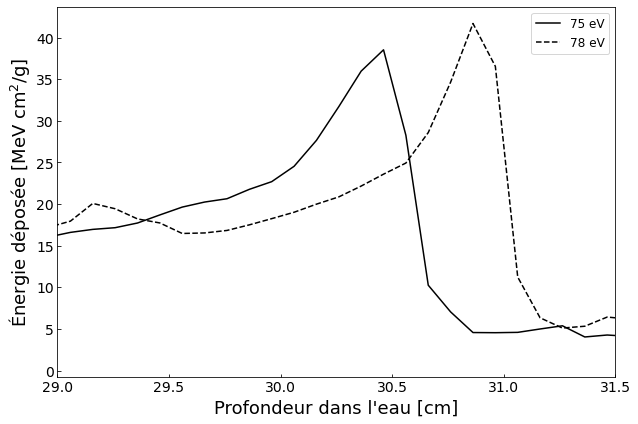

In [22]:

""" Le code ci-bas génère la figure 6.13 du manuel de référence, soit le dépôt de la dose à différentes profondeurs dans un fantôme d'eau avec des valeurs de I_w différentes (67, 75 et 80eV)."""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. """

field_size = 100 # cm2
i_values = np.array([75, 78])      # eV
energies_c = np.array([430, 430, 430])      # MeV/u, u = 12
nbr_c = np.array([10000, 10000, 10000]) # nbr d'ions de carbone simulés pour chaque énergie
tot_depths = np.array([50, 50]) # profondeur des scorers pour chaque particule, en cm
in_fluence_c = nbr_c/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

""" initialisation des données """
std_rel_c = np.empty(np.size(energies_c))

""" initialisation de la figure """

fig1 = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(2, 1, 2)      # carbone
plt.xlabel("Profondeur dans l'eau [cm]", fontsize='18')
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='18')
plt.tick_params(direction='in',labelsize='14')

marker = ['-','--']


for i in range(len(i_values)):
    i_value = i_values[i]
    path = r"/Users/pdionne/Université/Maîtrise/A23/Phys des radiations/Devoir/Proton - A23/6_13_carbon_430MeV_Iw_{}eV_vf.csv".format(i_value)
    bins, dose, std = csv_to_data(path)

    # erreur relative
    std_rel_c[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel_c[i] < 3: # erreur maximale est choisie à 3%
        print("Ion de carbone de ", i_value, "eV - Erreur relative suffisante atteinte!")
        print(format(std_rel_c[i], '.3g'), "% <", "3 %")
    else:
        print("Ion de carbone ", i_value, "eV - Erreur relative trop élevée")
        print(format(std_rel_c[i], '.3g'), "% >", "3 %")

    # conversion dose et profondeur
    depth = bins * tot_depths[1]/len(bins)
    dose = dose/(10000*MeV_to_joule*in_fluence_c[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

# Figure
    ax1.plot(depth, dose, marker[i], label="{} eV".format(i_value), color="k")

    ax1.set_xlim([29, 31.5])
    ax1.legend(loc=0, frameon=True, fontsize='12')


En utilisant l'eau prédéfinie par Geant4 (Water_75eV et G4_WATER) qui ont une _mean excitation energy_ de 75eV et 78eV, il est possible de voir l'augmentation de la profondeur à laquelle le pic de Bragg apparaît dans le milieu. Le premier pic de Bragg pour le _I_ de 75eV est à 30.5cm du début du fantôme alors que pour celui de 78eV, le pic se retrouve à 30.8cm de la surface. 

Selon le Attix, pour chaque changement de 2 eV dans la valeur de _I_, ont s'attend à un déplacement de 1 mm du pic de Bragg. Ici, pour une variation de 3 eV, nous avons une variation de 3 mm, ce qui est le double de ce qui est attendu. Cette variation peut être explicable par les listes de "physiques" utilisées qui ne sont pas toutes à faites appropriées pour les simulations effectuées.

 Pour revenir à l'argument avançant qu'il est possible d'atteindre une précision sub-millimétrique pour les faisceau de protons et de carbones, ce dernier n'est pas valable comme il a été démontré ici et par Andreo (_On the clinical spatial resolution achievable with protons and heavier charged particle radiotherapy beams_, 2009, _Phys. Med. Biol_. 54). En effet, comme le corps humain est composé d'une variété de tissus différents ayant différentes valeurs de _mean excitation energy_, il serait nécessaire d'augmenter le volume de traitement clinique afin de tenir compte de la variation de profondeur à laquelle le pic de Bragg se produit. Il est également important de tenir compte que la position du pic de Bragg est également dépendant de l'énergie du faisceau de traitement, comme démontré à la figure précédente et dans le livre d'Attix à la figure 6.12.



## Beam quality of a pristine and modulated beam of proton

## Références

[1] P. Andreo, D. T. Burns, A. E. Nahum, J. Seuntjens, and F. H. Attix, Fundamentals of Ionizing Radiation Dosimetry, 1er édition. Wiley-VCH, 2017.

[2] P. Andreo, “On the clinical spatial resolution achievable with protons and heavier charged particle radiotherapy beams,” Phys. Med. Biol., vol. 54, no. 11, p. N205, May 2009, doi: 10.1088/0031-9155/54/11/N01.

[3] M. Testa et al., “Experimental validation of the TOPAS Monte Carlo system for passive scattering proton therapy,” Med Phys, vol. 40, no. 12, p. 121719, Dec. 2013, doi: 10.1118/1.4828781.